<a href="https://colab.research.google.com/github/NikNord174/GAN_sandbox/blob/main/Convolutional%20GAN_AnimeFaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Convolutional GAN in PyTorch

In [78]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
!unzip 'animeface-character-dataset.zip'

unzip:  cannot find or open animeface-character-dataset.zip, animeface-character-dataset.zip.zip or animeface-character-dataset.zip.ZIP.


In [80]:
from IPython.display import clear_output

!tar -xzvf '/content/drive/MyDrive/data.tgz'
clear_output()

In [84]:
#setting parameters
import numpy as np

batch_size=8
latent_dim=100
lr=0.0002
b1=0.5
b2=0.999
n_epochs=200
image_shape = (3, 64, 64)
image_dim = int(np.prod(image_shape))

In [83]:
#creating Dataset with anime faces
import torch
import torchvision
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torchvision import datasets
from torch.utils.data.dataset import Dataset
from PIL import Image
import os

class AnimeFaces(Dataset):
  def __init__(self):
    self.data_path='/content/cropped/'
    self.n_samples=len(os.listdir(self.data_path))
    self.transform=Compose([Resize((64,64)),
                            ToTensor(),
                            Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
    

  def __len__(self):
    return self.n_samples

  def __getitem__(self, idx):
    i=0
    files=os.listdir(self.data_path)
    #files=files[:int(len(files)/2)]
    if files[idx].endswith('.jpg'):
      try:
        img=Image.open(self.data_path+files[idx])
        #img.verify() # verify that it is, in fact an image
        
      except (IOError, SyntaxError,UnboundLocalError) as e:
        #print('Bad file:', files[idx]) # print out the names of corrupt files
        img=Image.open(self.data_path+'411_2000.jpg')
        i+=1
    img=self.transform(img)
    return img

In [85]:
from torch.utils.data import DataLoader

train_loader=DataLoader(dataset=AnimeFaces(), batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


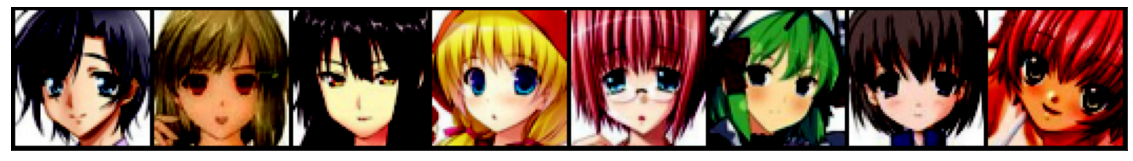

In [87]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def show_images(images):
  fig,ax=plt.subplots(figsize=(20,20))
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(make_grid(images.detach(),nrow=8).permute(1,2,0))

def show_batch(train_loader):
  for images in train_loader:
    show_images(images)
    break

show_batch(train_loader)

In [88]:
#weights initialization
def weights_init(m):
  classname=m.__class__.__name__
  if classname.find('Conv')!=-1:
    torch.nn.init.normal_(m.weight,0.0,0.02)
  elif classname.find('BatchNorm')!=-1:
    torch.nn.init.normal_(m.weight,1.0,0.02)
    torch.nn.init.zeros_(m.bias)

In [89]:
#Generator Model
from torch import nn

class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()

    self.model=nn.Sequential(
        nn.ConvTranspose2d(in_channels=latent_dim,
                           out_channels=64*8,
                           kernel_size=4,
                           stride=1,
                           padding=0,
                           bias=False),
        nn.BatchNorm2d(64*8),
        nn.ReLU(True),

        nn.ConvTranspose2d(64*8,64*4,4,2,1,bias=False),
        nn.BatchNorm2d(64*4),
        nn.ReLU(True),

        nn.ConvTranspose2d(64*4,64*2,4,2,1,bias=False),
        nn.BatchNorm2d(64*2),
        nn.ReLU(True),
        
        nn.ConvTranspose2d(64*2,64,4,2,1,bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),

        nn.ConvTranspose2d(64,3,4,2,1,bias=False),
        nn.Tanh()
        )
    
  def forward(self,input):
    output=self.model(input)
    return output

Generator()

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [90]:
#Discriminator model
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.model=nn.Sequential(
        nn.Conv2d(in_channels=3,
                  out_channels=64,
                  kernel_size=4,
                  stride=2,
                  padding=1,
                  bias=False),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(64,64*2,4,2,1,bias=False),
        nn.BatchNorm2d(64*2),
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(64*2,64*4,4,2,1,bias=False),
        nn.BatchNorm2d(64*4),
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(64*4,64*8,4,2,1,bias=False),
        nn.BatchNorm2d(64*8),
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(64*8,1,4,1,0,bias=False),
        nn.Sigmoid(),
        nn.Flatten()
        )
    
  def forward(self, input):
    output=self.model(input)
    return output

Discriminator()

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
    (13): Flatten(start_dim=1, end_

In [91]:
import torch.optim as optim

#Loss Function
bce_function=nn.BCELoss()

#Generator Loss
def generator_loss(fake_output, label):
  gen_loss=bce_function(fake_output,label)
  return gen_loss

#Discriminator Loss
def discriminator_loss(output,label):
  disc_loss=bce_function(output, label)
  return disc_loss

#Optimization
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator=Generator().to(device)
generator.apply(weights_init)
discriminator=Discriminator().to(device)
discriminator.apply(weights_init)

G_optimizer=optim.Adam(generator.parameters(), lr=lr, betas=((b1,b2)))
D_optimizer=optim.Adam(discriminator.parameters(), lr=lr, betas=((b1,b2)))

In [92]:
!mkdir results

mkdir: cannot create directory ‘results’: File exists


In [ ]:
#training the model
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import save_image

#writer = SummaryWriter('diff-run/py-gan')
D_loss_plot=[]
G_loss_plot=[]
for epoch in range(1,n_epochs+1):
  D_loss_list=[]
  G_loss_list=[]
  for index,real_images in enumerate(train_loader):
    real_images=real_images.to(device)

    noise_vector=torch.randn(real_images.size(0),latent_dim,1,1,device=device)
    noise_vector=noise_vector.to(device)
    generated_image=generator(noise_vector)

    real_target=torch.ones(real_images.size(0)).to(device)
    fake_target=torch.zeros(real_images.size(0)).to(device)
    real_target = real_target.unsqueeze(1)
    fake_target = fake_target.unsqueeze(1)

    #discriminator work
    D_optimizer.zero_grad()
    
    output=discriminator(real_images)
    D_real_loss=discriminator_loss(output,real_target)
    
    output=discriminator(generated_image)
    D_fake_loss=discriminator_loss(output,fake_target)

    D_total_loss=(D_real_loss+D_fake_loss)/2
    D_loss_list.append(D_total_loss)

    D_total_loss.backward(retain_graph=True)
    D_optimizer.step()

    #generator work
    G_optimizer.zero_grad()

    output=discriminator(generated_image)
    G_loss=generator_loss(output,real_target)
    G_loss_list.append(G_loss)

    G_loss.backward()
    G_optimizer.step()

    im=generated_image.data
    #writer.add_scalar('Discriminator Loss',
    #                  D_total_loss,
    #                  epoch*len(train_loader)+index)
    #writer.add_scalar('Generator Loss',
    #                  G_loss,
    #                  epoch*len(train_loader)+index)

  #writing data on each epoch
  print('Epoch: [%d/%d]: D_loss: %.3f, G_loss: $.3f' %(epoch,n_epochs,
                                                       torch.mean(torch.FloatTensor(D_loss_list)),
                                                       torch.mean(torch.FloatTensor(G_loss_list))))
  
  D_loss_plot.append(torch.mean(torch.FloatTensor(D_total_loss)))
  G_loss_plot.append(torch.mean(torch.FloatTensor(G_loss)))
  save_image(generated_image.data,'/content/results/sample_%d'%epoch + '.png')#, nrow=10, normalize=True))
    